# Ноутбук c примерами работы со средой  Gym-GPN

##  Загрузка библиотек

In [852]:
import gym
import gym_gpn

In [853]:
from time import sleep
import numpy as np

## Создание объекта среды

In [854]:
env = gym.make('gpn-v0')

In [855]:
# создание инстанста виртуальной АЗС
env.create_thread(token = 'a7bf92fc-2bd6-4ab6-9180-9f403f8d490b')

# Методы среды `gym_gpn`

## `.step()` – запуск среды по шагам (итерациям)

### Один шаг

In [856]:
# Совершение одного шага в среде.
# Среда принимает действие и возвращает кортеж (observation, reward, done, info).
res = env.step(100)
res

({'cost': 35,
  'date_time': '2018-06-01T00:00:00',
  'price': 55.0,
  'volume': 82.43},
 4533.650000000001,
 False,
 {})

In [857]:
# observation
print('date_time: ', res[0]['date_time'])
print('price: ', res[0]['price'])
print('cost: ', res[0]['cost'])
print('volume: ', res[0]['volume'])

# reward, done, info
print('reward: ', res[1])
print('done (flag): ', res[2])
print('additional data: ', res[3])

date_time:  2018-06-01T00:00:00
price:  55.0
cost:  35
volume:  82.43
reward:  4533.650000000001
done (flag):  False
additional data:  {}


## `.reset()` – cброс среды к начальному состоянию

In [858]:
env.reset()
print(env.state)

None


# Пример агентной модели

## Загрузка библиотек

In [859]:
import sys
sys.path.append('./examples/agents/')
from random_walk import RandomWalkAgent

## RandomWalkAgent

In [860]:
agnt = RandomWalkAgent(env.low_price, env.high_price)

In [861]:
# действие
agnt.act()

32

In [862]:
# ts = []
# for i in range(11):
#     env.reset()
#     done = env.done
#     while not done:
#         try:
#             price = agnt.act()
#             ob, reward, done, _ = env.step(35+i*2)
#             ts.append([ob, reward])
#         except:
#             continue

# import pickle
# with open('all_data.pkl', 'wb') as f:
#     pickle.dump(ts, f)

# env.cum_reward

# Visualize some data

In [863]:
import pickle
with open('all_data.pkl', 'rb') as f:
    ts = pickle.load(f)

In [864]:
import pandas as pd

In [865]:
X = []
for el in ts:
    X.append(el[0])

In [866]:
X = pd.DataFrame.from_dict(X)

In [867]:
X.drop(columns  = ['cost'], inplace = True)

In [868]:
X.date_time = pd.to_datetime(X.date_time)

In [869]:
X['reward'] = X.price.values * X.volume.values

In [870]:
X['year'] = X['date_time'].map(lambda x: x.year)

In [871]:
X['month'] = X['date_time'].map(lambda x: x.month)

In [872]:
X['day'] = X['date_time'].map(lambda x: x.day)

In [873]:
X['hour'] = X['date_time'].map(lambda x: x.hour)

In [874]:
X.head()

,date_time,price,volume,reward,year,month,day,hour
0,2018-06-01 00:00:00,35.0,97.40,3409.00,2018,6,1,0
1,2018-06-01 01:00:00,35.0,63.62,2226.70,2018,6,1,1
2,2018-06-01 02:00:00,35.0,48.93,1712.55,2018,6,1,2
3,2018-06-01 03:00:00,35.0,46.60,1631.00,2018,6,1,3
4,2018-06-01 04:00:00,35.0,59.42,2079.70,2018,6,1,4


In [875]:
df_max = X.groupby('date_time', as_index = False).apply(lambda x: x.loc[x.reward == x.reward.max()])

In [876]:
df_max.index = df_max.index.droplevel()

In [877]:
df_max.reset_index(drop = True, inplace = True)

In [878]:
df_max['day_of_week'] = df_max['date_time'].apply(lambda x: x.dayofweek)

In [879]:
df_max = df_max.loc[df_max.drop(columns = ['price', 'date_time', 'volume', 'reward', 'year']).drop_duplicates().index, :]

In [880]:
from tqdm import tqdm_notebook

In [881]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [882]:
df_max['volume_autocor'] = autocorr(df_max['volume'].values)

In [883]:
df_max['price_autocor'] = autocorr(df_max['price'].values)

In [884]:
df_max.head()

,date_time,price,volume,reward,year,month,day,hour,day_of_week,volume_autocor,price_autocor
0,2018-06-01 00:00:00,55.0,82.43,4533.65,2018,6,1,0,4,3.137635e+08,5972272.0
1,2018-06-01 01:00:00,55.0,53.56,2945.80,2018,6,1,1,4,3.069681e+08,5954599.0
2,2018-06-01 02:00:00,55.0,42.14,2317.70,2018,6,1,2,4,2.935467e+08,5947454.0
3,2018-06-01 03:00:00,55.0,34.38,1890.90,2018,6,1,3,4,2.766243e+08,5942225.0
4,2018-06-01 04:00:00,55.0,38.36,2109.80,2018,6,1,4,4,2.586151e+08,5938280.0


In [885]:
# List of columns that we will use to create lags

cols_to_rename = ['volume', 'price']
index_cols = ['date_time']
shift_range = [28*7+1, 35*7+1]

for hour_shift in tqdm_notebook(shift_range):
    train_shift = df_max[index_cols + cols_to_rename].copy()
    
    train_shift['date_time'] = train_shift['date_time'] + np.timedelta64(hour_shift, 'h')
    
    foo = lambda x: '{}_lag_hour_{}'.format(x, hour_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    df_max = pd.merge(df_max, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

In [886]:
# List of columns that we will use to create lags

cols_to_rename = ['volume', 'price']
index_cols = ['date_time']
shift_range = [29, 30, 35]

for day_shift in tqdm_notebook(shift_range):
    train_shift = df_max[index_cols + cols_to_rename].copy()
    
    train_shift['date_time'] = train_shift['date_time'] + np.timedelta64(day_shift, 'D')
    
    foo = lambda x: '{}_lag_day_{}'.format(x, day_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    df_max = pd.merge(df_max, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

df_max = df_max[df_max.date_time >= pd.Timestamp('2018-07-06 00:00:0')]

In [887]:
data = df_max.drop(columns = ['date_time', 'reward', 'year', 'day', 'month'])

In [888]:
data.head()

,price,volume,hour,day_of_week,volume_autocor,price_autocor,volume_lag_hour_197,price_lag_hour_197,volume_lag_hour_246,price_lag_hour_246,volume_lag_day_29,price_lag_day_29,volume_lag_day_30,price_lag_day_30,volume_lag_day_35,price_lag_day_35
840,55.0,81.86,0,4,1.766332e+08,3474664.0,464.60,55.0,449.56,55.0,173.24,55.0,98.12,55.0,82.43,55.0
841,55.0,51.84,1,4,1.742870e+08,3470151.0,419.26,55.0,396.41,55.0,108.15,55.0,51.95,55.0,53.56,55.0
842,55.0,39.50,2,4,1.685674e+08,3467242.0,303.23,55.0,427.55,55.0,58.72,55.0,37.11,55.0,42.14,55.0
843,55.0,32.00,3,4,1.601201e+08,3463565.0,241.88,55.0,413.00,55.0,41.31,55.0,41.58,55.0,34.38,55.0
844,55.0,36.20,4,4,1.500514e+08,3460540.0,214.46,55.0,307.59,55.0,39.79,55.0,39.01,55.0,38.36,55.0


In [889]:
# data['volume_lag_hour_197'] -= data.volume_lag_hour_198

In [890]:
# data['price_lag_hour_197'] -= data.price_lag_hour_198

In [891]:
data['price_lag_day_29'] -= data.price_lag_day_30
data['price_lag_day_30'] -= data.price_lag_day_35

In [892]:
data['volume_lag_day_29'] -= data.volume_lag_day_30
data['volume_lag_day_30'] -= data.volume_lag_day_35

In [893]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

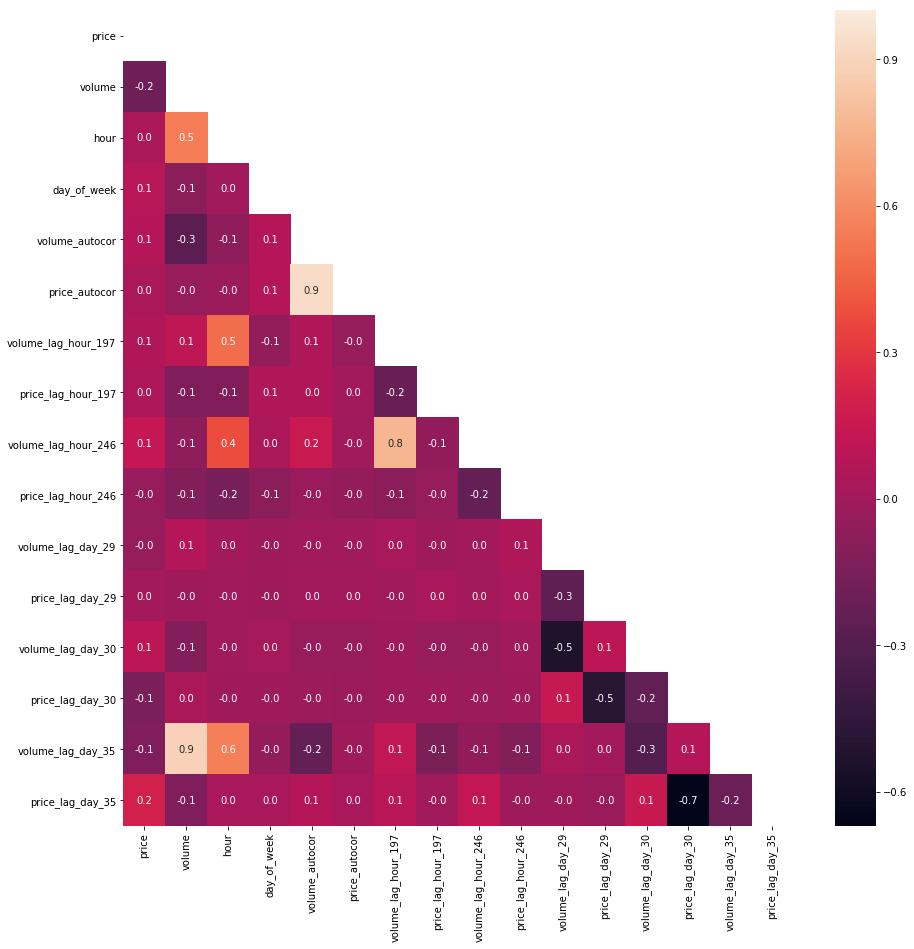

In [894]:
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(data.corr(), mask = mask, annot=True, fmt= '.1f', ax = ax)

In [896]:
from sklearn.model_selection import train_test_split as tts

X_train, y_train = data.loc[:1344, :].drop(columns = ['volume']), data.loc[:1344, :].price.values
X_test, y_test = data.loc[1344:, :].drop(columns = ['volume']), data.loc[1344:, :].price.values
from catboost import CatBoostRegressor

tree = CatBoostRegressor(iterations= 1000, learning_rate= 0.1, depth=2, use_best_model=True)
tree.fit(X_train, y_train, cat_features=[1,2], eval_set=[(X_test, y_test)], plot = True)

0:	learn: 49.1588973	test: 49.0796444	best: 49.0796444 (0)	total: 1.57ms	remaining: 1.56s
1:	learn: 44.3482153	test: 44.2648127	best: 44.2648127 (1)	total: 3.66ms	remaining: 1.82s
2:	learn: 40.0065869	test: 39.9364804	best: 39.9364804 (2)	total: 4.69ms	remaining: 1.56s
3:	learn: 36.0923233	test: 36.0405966	best: 36.0405966 (3)	total: 6.43ms	remaining: 1.6s
4:	learn: 32.5503312	test: 32.4998880	best: 32.4998880 (4)	total: 8.4ms	remaining: 1.67s
5:	learn: 29.3876982	test: 29.3481890	best: 29.3481890 (5)	total: 9.54ms	remaining: 1.58s
6:	learn: 26.4946884	test: 26.4620957	best: 26.4620957 (6)	total: 11.3ms	remaining: 1.61s
7:	learn: 23.8914708	test: 23.8629148	best: 23.8629148 (7)	total: 13.9ms	remaining: 1.73s
8:	learn: 21.5708920	test: 21.5633353	best: 21.5633353 (8)	total: 16ms	remaining: 1.76s
9:	learn: 19.4477798	test: 19.4395995	best: 19.4395995 (9)	total: 18.1ms	remaining: 1.79s
10:	learn: 17.5664284	test: 17.5467877	best: 17.5467877 (10)	total: 20.4ms	remaining: 1.84s
11:	learn: 1

120:	learn: 0.3591083	test: 1.0193267	best: 1.0193267 (120)	total: 191ms	remaining: 1.39s
121:	learn: 0.3588375	test: 1.0192427	best: 1.0192427 (121)	total: 192ms	remaining: 1.38s
122:	learn: 0.3588302	test: 1.0191549	best: 1.0191549 (122)	total: 194ms	remaining: 1.38s
123:	learn: 0.3588137	test: 1.0190559	best: 1.0190559 (123)	total: 195ms	remaining: 1.38s
124:	learn: 0.3582696	test: 1.0188932	best: 1.0188932 (124)	total: 196ms	remaining: 1.38s
125:	learn: 0.3579355	test: 1.0186852	best: 1.0186852 (125)	total: 198ms	remaining: 1.37s
126:	learn: 0.3579207	test: 1.0185967	best: 1.0185967 (126)	total: 199ms	remaining: 1.37s
127:	learn: 0.3563587	test: 1.0185469	best: 1.0185469 (127)	total: 201ms	remaining: 1.37s
128:	learn: 0.3561801	test: 1.0185195	best: 1.0185195 (128)	total: 202ms	remaining: 1.37s
129:	learn: 0.3560286	test: 1.0184926	best: 1.0184926 (129)	total: 204ms	remaining: 1.36s
130:	learn: 0.3559804	test: 1.0183907	best: 1.0183907 (130)	total: 205ms	remaining: 1.36s
131:	learn

250:	learn: 0.2804362	test: 0.9586390	best: 0.9553972 (220)	total: 381ms	remaining: 1.14s
251:	learn: 0.2800884	test: 0.9586949	best: 0.9553972 (220)	total: 383ms	remaining: 1.14s
252:	learn: 0.2800867	test: 0.9586536	best: 0.9553972 (220)	total: 385ms	remaining: 1.14s
253:	learn: 0.2794317	test: 0.9586326	best: 0.9553972 (220)	total: 387ms	remaining: 1.14s
254:	learn: 0.2779489	test: 0.9568501	best: 0.9553972 (220)	total: 389ms	remaining: 1.14s
255:	learn: 0.2779389	test: 0.9567902	best: 0.9553972 (220)	total: 390ms	remaining: 1.13s
256:	learn: 0.2755600	test: 0.9540160	best: 0.9540160 (256)	total: 391ms	remaining: 1.13s
257:	learn: 0.2755341	test: 0.9540090	best: 0.9540090 (257)	total: 393ms	remaining: 1.13s
258:	learn: 0.2746170	test: 0.9532300	best: 0.9532300 (258)	total: 394ms	remaining: 1.13s
259:	learn: 0.2737664	test: 0.9528816	best: 0.9528816 (259)	total: 396ms	remaining: 1.13s
260:	learn: 0.2732035	test: 0.9528842	best: 0.9528816 (259)	total: 398ms	remaining: 1.13s
261:	learn

349:	learn: 0.2393829	test: 0.7523852	best: 0.7523852 (349)	total: 573ms	remaining: 1.06s
350:	learn: 0.2393368	test: 0.7530466	best: 0.7523852 (349)	total: 575ms	remaining: 1.06s
351:	learn: 0.2392961	test: 0.7536510	best: 0.7523852 (349)	total: 576ms	remaining: 1.06s
352:	learn: 0.2392938	test: 0.7536297	best: 0.7523852 (349)	total: 577ms	remaining: 1.06s
353:	learn: 0.2392514	test: 0.7535984	best: 0.7523852 (349)	total: 578ms	remaining: 1.05s
354:	learn: 0.2391773	test: 0.7536442	best: 0.7523852 (349)	total: 579ms	remaining: 1.05s
355:	learn: 0.2391727	test: 0.7535975	best: 0.7523852 (349)	total: 580ms	remaining: 1.05s
356:	learn: 0.2391656	test: 0.7535679	best: 0.7523852 (349)	total: 581ms	remaining: 1.05s
357:	learn: 0.2391628	test: 0.7535352	best: 0.7523852 (349)	total: 583ms	remaining: 1.04s
358:	learn: 0.2391006	test: 0.7534633	best: 0.7523852 (349)	total: 588ms	remaining: 1.05s
359:	learn: 0.2390801	test: 0.7540089	best: 0.7523852 (349)	total: 589ms	remaining: 1.05s
360:	learn

MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

508:	learn: 0.2129748	test: 0.6731000	best: 0.6726075 (503)	total: 964ms	remaining: 930ms
509:	learn: 0.2128214	test: 0.6732290	best: 0.6726075 (503)	total: 966ms	remaining: 928ms
510:	learn: 0.2127565	test: 0.6732677	best: 0.6726075 (503)	total: 967ms	remaining: 925ms
511:	learn: 0.2127376	test: 0.6732727	best: 0.6726075 (503)	total: 968ms	remaining: 923ms
512:	learn: 0.2127354	test: 0.6732866	best: 0.6726075 (503)	total: 970ms	remaining: 921ms
513:	learn: 0.2127276	test: 0.6721532	best: 0.6721532 (513)	total: 1.01s	remaining: 957ms
514:	learn: 0.2126740	test: 0.6720953	best: 0.6720953 (514)	total: 1.02s	remaining: 964ms
515:	learn: 0.2126553	test: 0.6721131	best: 0.6720953 (514)	total: 1.02s	remaining: 962ms
516:	learn: 0.2126485	test: 0.6721033	best: 0.6720953 (514)	total: 1.03s	remaining: 959ms
517:	learn: 0.2118594	test: 0.6521672	best: 0.6521672 (517)	total: 1.03s	remaining: 957ms
518:	learn: 0.2118153	test: 0.6520649	best: 0.6520649 (518)	total: 1.03s	remaining: 955ms
519:	learn

676:	learn: 0.1938804	test: 0.5728584	best: 0.5725554 (671)	total: 1.35s	remaining: 646ms
677:	learn: 0.1938109	test: 0.5729130	best: 0.5725554 (671)	total: 1.36s	remaining: 645ms
678:	learn: 0.1938103	test: 0.5729087	best: 0.5725554 (671)	total: 1.36s	remaining: 642ms
679:	learn: 0.1936697	test: 0.5729614	best: 0.5725554 (671)	total: 1.36s	remaining: 640ms
680:	learn: 0.1936337	test: 0.5729506	best: 0.5725554 (671)	total: 1.36s	remaining: 638ms
681:	learn: 0.1936315	test: 0.5729300	best: 0.5725554 (671)	total: 1.36s	remaining: 635ms
682:	learn: 0.1936296	test: 0.5729205	best: 0.5725554 (671)	total: 1.36s	remaining: 634ms
683:	learn: 0.1936294	test: 0.5729147	best: 0.5725554 (671)	total: 1.37s	remaining: 631ms
684:	learn: 0.1936195	test: 0.5728739	best: 0.5725554 (671)	total: 1.37s	remaining: 629ms
685:	learn: 0.1935901	test: 0.5729882	best: 0.5725554 (671)	total: 1.37s	remaining: 627ms
686:	learn: 0.1935865	test: 0.5729818	best: 0.5725554 (671)	total: 1.37s	remaining: 625ms
687:	learn

869:	learn: 0.1760478	test: 0.5359668	best: 0.5355188 (858)	total: 1.74s	remaining: 260ms
870:	learn: 0.1759705	test: 0.5360571	best: 0.5355188 (858)	total: 1.74s	remaining: 258ms
871:	learn: 0.1759624	test: 0.5360854	best: 0.5355188 (858)	total: 1.74s	remaining: 256ms
872:	learn: 0.1755165	test: 0.5358792	best: 0.5355188 (858)	total: 1.75s	remaining: 254ms
873:	learn: 0.1755154	test: 0.5358749	best: 0.5355188 (858)	total: 1.75s	remaining: 252ms
874:	learn: 0.1755112	test: 0.5358678	best: 0.5355188 (858)	total: 1.75s	remaining: 250ms
875:	learn: 0.1755069	test: 0.5358410	best: 0.5355188 (858)	total: 1.75s	remaining: 248ms
876:	learn: 0.1755068	test: 0.5358376	best: 0.5355188 (858)	total: 1.75s	remaining: 246ms
877:	learn: 0.1755060	test: 0.5358509	best: 0.5355188 (858)	total: 1.75s	remaining: 244ms
878:	learn: 0.1754893	test: 0.5358660	best: 0.5355188 (858)	total: 1.75s	remaining: 242ms
879:	learn: 0.1754892	test: 0.5358622	best: 0.5355188 (858)	total: 1.76s	remaining: 240ms
880:	learn

986:	learn: 0.1687971	test: 0.5183697	best: 0.5183451 (985)	total: 1.93s	remaining: 25.4ms
987:	learn: 0.1683800	test: 0.5173242	best: 0.5173242 (987)	total: 1.93s	remaining: 23.5ms
988:	learn: 0.1683446	test: 0.5171448	best: 0.5171448 (988)	total: 1.93s	remaining: 21.5ms
989:	learn: 0.1681728	test: 0.5172421	best: 0.5171448 (988)	total: 1.94s	remaining: 19.5ms
990:	learn: 0.1681710	test: 0.5172273	best: 0.5171448 (988)	total: 1.94s	remaining: 17.6ms
991:	learn: 0.1681696	test: 0.5172141	best: 0.5171448 (988)	total: 1.94s	remaining: 15.6ms
992:	learn: 0.1681514	test: 0.5172076	best: 0.5171448 (988)	total: 1.94s	remaining: 13.7ms
993:	learn: 0.1681514	test: 0.5172042	best: 0.5171448 (988)	total: 1.94s	remaining: 11.7ms
994:	learn: 0.1681511	test: 0.5172013	best: 0.5171448 (988)	total: 1.94s	remaining: 9.76ms
995:	learn: 0.1681508	test: 0.5171918	best: 0.5171448 (988)	total: 1.94s	remaining: 7.8ms
996:	learn: 0.1681393	test: 0.5172277	best: 0.5171448 (988)	total: 1.95s	remaining: 5.85ms


In [897]:
preds = tree.predict(X_test)

In [947]:
def func3(x):
    df = pd.DataFrame()
    x_c = x.copy()
    for i in range(11):
        x_c['price'] = 35 + i*2
        df = pd.concat([df, x_c])
    return np.argmax(tree.predict(df))*2 + 35

In [948]:
preds = []
for i in range(len(X_test)):
    preds.append(func3(X_test.loc[1344+i:1344+i, :]))

In [952]:
env = gym.make('gpn-v0')
env.create_thread(token='df133af2-dccb-4f06-b31f-bf99c02b1ba9')

done = env.done
i = 0
while not done:
    try:
        price = preds[i]
        ob, reward, done, _ = env.step(price)
        print(str(ob['date_time']) + ',' + str(env.cum_reward*10 // 10) + ',' + str(price*10//10) + ',' + str(done), end = '')
        print('\r', end='')
        i+=1
    except:
        break
print()

2018-08-23T23:00:00,12525274.0,55,False


In [774]:
env.cum_reward

12509095.912999999

In [ ]:
# best model without test lags 12515592.899800003 err ~ 13k
# best model by now eror ~ 9k

In [314]:
# максимум = 12528666.630000003
# all_55 =   12525274.85 err ~ 3.3k

# Ниже все очень грязно, не смотрите туда

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
def func(x):
    arr =x['reward'].values - x['reward'].loc[x.price == 55].values[0]
    x['flag'] = all(i <= 0 for i in arr)
    return x

In [23]:
def func1(x):
    max = -1
    for i in range(len(x.reward.values)):
        for j in range(i+1, len(x.reward.values)):
            if max < abs(x.reward.values[i] - x.reward.values[j]):
                max = abs(x.reward.values[i] - x.reward.values[j])
    max_arr = []
    for i in range(len(x)):
        max_arr.append(max)
    x['max_diff'] = max_arr
    return x

In [24]:
max_diff = X.groupby(['date_time'], as_index = False).apply(func1)

In [25]:
grouped = max_diff.groupby(['date_time'], as_index = False).apply(func)

In [26]:
group = max_diff.loc[max_diff.date_time.isin(grouped.loc[grouped.flag == False].date_time.unique())].groupby(['date_time'], as_index = False)



In [27]:
best_not_55 = group.apply(lambda x: x.loc[x.reward.argmax, :])

/Users/alexeydomrachev/anaconda3/lib/python3.6/site-packages/pandas/core/common.py:408: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return maybe_callable(obj, **kwargs)


In [28]:
ddf =best_not_55.drop(columns = best_not_55.columns[1:])

In [29]:
ddf['flag'] = np.ones((len(best_not_55), 1))

In [30]:
df_flag = pd.merge(max_diff, ddf, on=['date_time'], how = 'left').fillna(0)

In [76]:
df_flag

,date_time,price,volume,reward,year,month,day,hour,max_diff,flag,day_of_week
0,2018-06-01 00:00:00,35.0,97.40,3409.00,2018,6,1,0,1124.65,0.0,4
1,2018-06-01 01:00:00,35.0,63.62,2226.70,2018,6,1,1,719.10,0.0,4
2,2018-06-01 02:00:00,35.0,48.93,1712.55,2018,6,1,2,605.15,0.0,4
3,2018-06-01 03:00:00,35.0,46.60,1631.00,2018,6,1,3,259.90,0.0,4
4,2018-06-01 04:00:00,35.0,59.42,2079.70,2018,6,1,4,30.10,0.0,4
5,2018-06-01 05:00:00,35.0,119.78,4192.30,2018,6,1,5,384.80,0.0,4
6,2018-06-01 06:00:00,35.0,290.47,10166.45,2018,6,1,6,2111.20,0.0,4
7,2018-06-01 07:00:00,35.0,521.05,18236.75,2018,6,1,7,3453.05,0.0,4
8,2018-06-01 08:00:00,35.0,696.80,24388.00,2018,6,1,8,3068.55,0.0,4
9,2018-06-01 09:00:00,35.0,757.04,26496.40,2018,6,1,9,1341.85,0.0,4


In [32]:
df_flag['day_of_week'] = df_flag['date_time'].apply(lambda x: x.dayofweek)

In [47]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

dn['volume_autocor'] = autocorr(dn['volume'].values)

KeyboardInterrupt: 

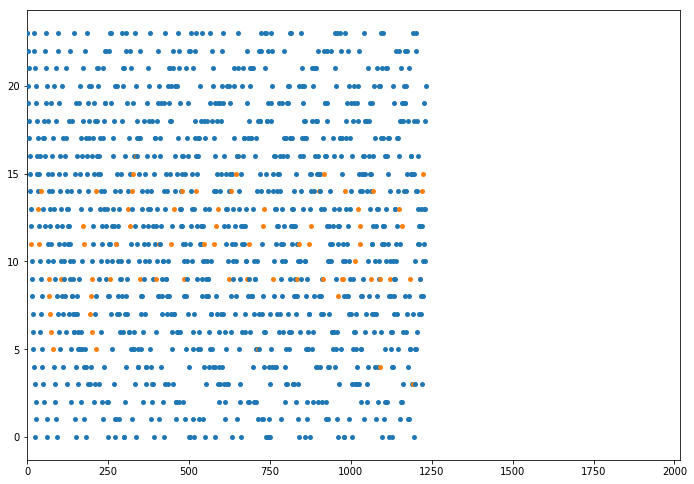

In [74]:
# dn = df_flag.loc[df_flag.price == 55]
# dfn = dn.groupby('day_of_week', as_index=False).reward.mean()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.swarmplot(data = dn, x = 'max_diff_autocor', y = 'hour', hue = 'flag', ax=ax, )
# sns.lineplot(data = dfn, x = 'day_of_week', y = 'reward', ax=ax, color = 'green')

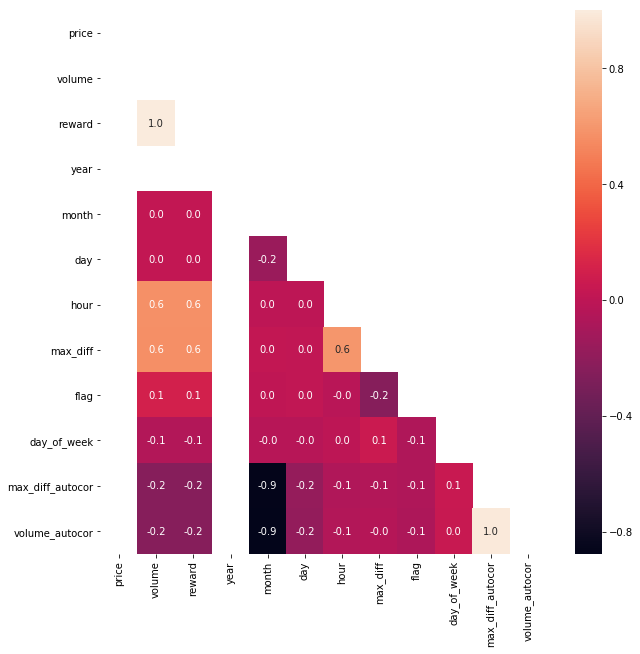

In [75]:
mask = np.zeros_like(dn.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(dn.corr(), mask = mask, annot=True, fmt= '.1f', ax = ax)

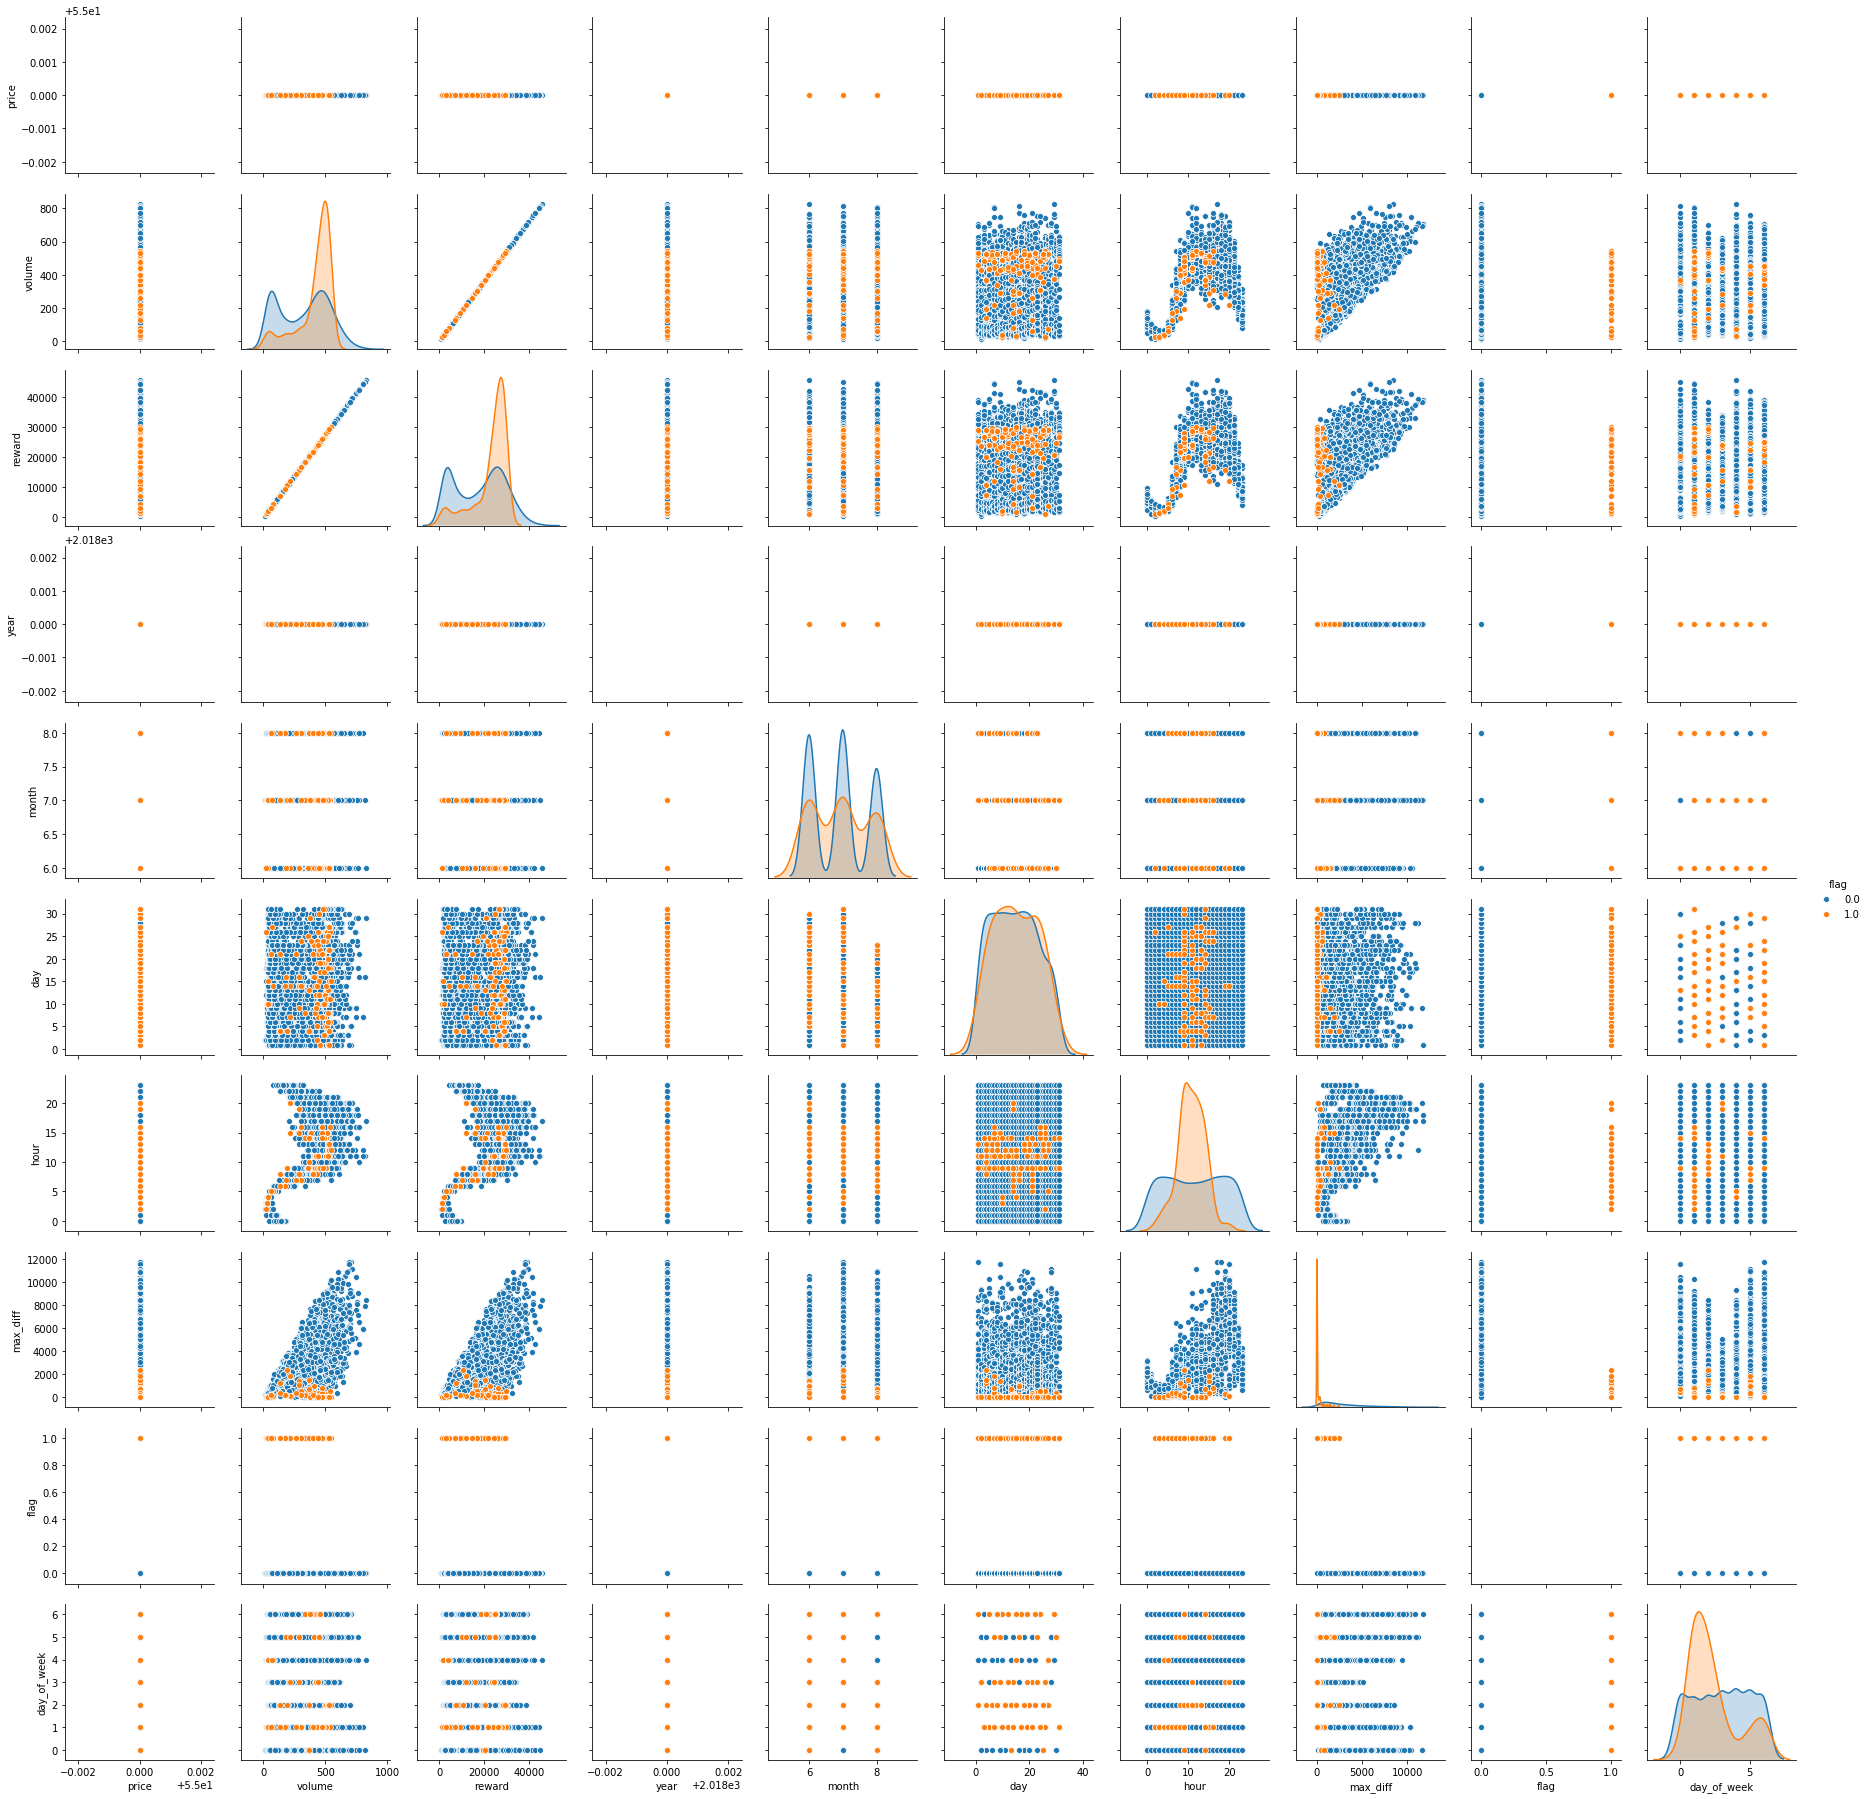

In [37]:
sns.pairplot(data = dn.drop(columns = ['date_time']), hue= 'flag')

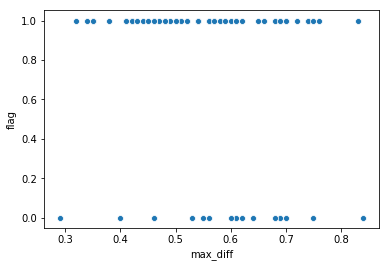

In [467]:
dn = df_flag.loc[:, ['max_diff', 'flag']].drop_duplicates()
dfff = dfff.loc[dfff.max_diff < 1]
dn['pred_max_diff'] = np.roll(dn.max_diff.values, 1)

dn.drop(0, inplace = True)

sns.scatterplot(dn.max_diff, dfff.flag)

In [230]:
X.groupby('date_time').reward.max().sum()

36665035.2

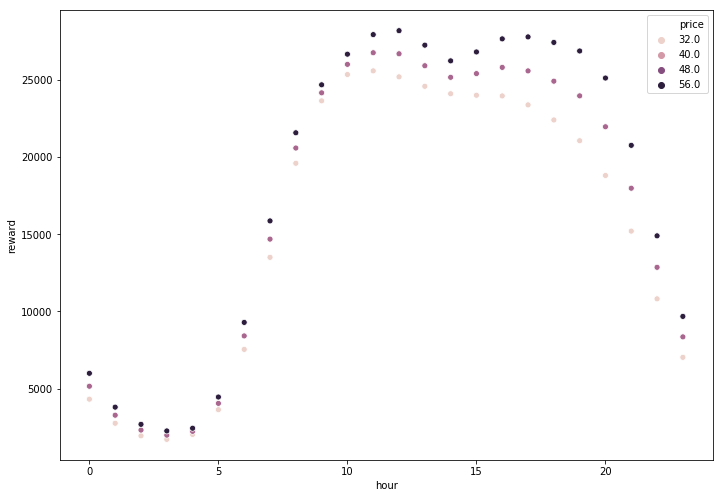

In [175]:
grouped = X.groupby(['price', 'hour'], as_index=False)['reward'].mean()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data = grouped.loc[grouped.price.isin([35, 45, 55])], x ='hour', y='reward', hue = 'price', ax = ax)